In [28]:
import pickle

import librosa.feature
import numpy as np
import tensorflow as tf

from keras import Input, Model
from keras.layers import Dense, Dropout
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.optimizers import Adam

from utilities.training_plots import plot_loss, plot_categorical_accuracy

## Define Feature Extraction

In [29]:
def get_mfcc(y, sr):
    return np.array(librosa.feature.mfcc(y=y, sr=sr))


def get_mel_spectrogram(y, sr):
    return np.array(librosa.feature.melspectrogram(y=y, sr=sr))


def get_chroma_vector(y, sr):
    return np.array(librosa.feature.chroma_stft(y=y, sr=sr))


def get_tonnetz(y, sr):
    return np.array(librosa.feature.tonnetz(y=y, sr=sr))


def get_zero_crossings(y):
    return librosa.zero_crossings(y, pad=False)


def get_zero_crossing_rate(y):
    return librosa.feature.zero_crossing_rate(y)


def get_feature(y, sr):
    mfcc = get_mfcc(y, sr)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    mel_spectrogram = get_mel_spectrogram(y, sr)
    mel_spectrogram_mean = mel_spectrogram.mean(axis=1)
    mel_spectrogram_min = mel_spectrogram.min(axis=1)
    mel_spectrogram_max = mel_spectrogram.max(axis=1)
    mel_spectrogram_feature = np.concatenate((mel_spectrogram_mean, mel_spectrogram_min, mel_spectrogram_max))

    chroma = get_chroma_vector(y, sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    tonnetz = get_tonnetz(y, sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    tonnetz_min = tonnetz.min(axis=1)
    tonnetz_max = tonnetz.max(axis=1)
    tonnetz_feature = np.concatenate((tonnetz_mean, tonnetz_min, tonnetz_max))

    """
    Adding the zero crossing seems to have increased accuracy, it's now at ~60%
    """
    zero_crossing_rate = get_zero_crossing_rate(y)
    zero_crossing_rate_mean = zero_crossing_rate.mean(axis=1)
    zero_crossing_rate_min = zero_crossing_rate.min(axis=1)
    zero_crossing_rate_max = zero_crossing_rate.max(axis=1)
    zero_crossing_feature = np.concatenate((
        zero_crossing_rate_mean,
        zero_crossing_rate_min,
        zero_crossing_rate_max
    ))

    return np.concatenate((
        chroma_feature,
        mel_spectrogram_feature,
        mfcc_feature,
        tonnetz_feature,
        zero_crossing_feature,
    ))

## Make Training Data

In [30]:
def make_training_data():
    with open('../pickles/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    xs = []
    ys = []
    for label, y, sr in data:
        features = get_feature(y, sr)
        xs.append(features)
        ys.append(label)
    xs = np.array(xs)
    ys = tf.one_hot(np.array(ys), 10)
    print(xs.shape)
    print(ys.shape)
    permutations = np.random.permutation(999)
    features = np.array(xs)[permutations]
    labels = np.array(ys)[permutations]
    features_train = features[0:700]
    labels_train = labels[0:700]
    features_validate = features[700:850]
    labels_validate = labels[700:850]
    features_test = features[850:999]
    labels_test = labels[850:999]
    data_set = (
        (labels_train, features_train),
        (labels_validate, features_validate),
        (labels_test, features_test)
    )
    with open('data_set.pkl', 'wb') as f:
        pickle.dump(data_set, f)

In [31]:
make_training_data()

(999, 501)
(999, 10)


## Define Training Data Loader

In [32]:
def load_data():
    with open('data_set.pkl', 'rb') as f:
        data_set = pickle.load(f)

    return data_set

## Define Build Model, Train and Evaluate Model

In [33]:
def build_model():
    inputs = Input(shape=501, name="feature")
    x = Dense(512, activation="relu", name="dense_1")(inputs)
    x = Dense(256, activation="relu", name="dense_2")(x)
    x = Dropout(0.1, name="dropout_1")(x)
    x = Dense(128, activation="relu", name="dense_3")(x)
    x = Dropout(0.1, name="dropout_2")(x)
    outputs = Dense(10, activation="softmax", name="predictions")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()],
    )
    model.summary()

    return model


def train(model, data_set):
    return model.fit(
        x=data_set[0][1].tolist(),
        y=data_set[0][0].tolist(),
        verbose=1,
        validation_data=(data_set[1][1].tolist(), data_set[1][0].tolist()),
        epochs=30
    )


def evaluate_model(model, data_set):
    return model.evaluate(x=data_set[2][1].tolist(), y=data_set[2][0].tolist(), verbose=0, return_dict=True)


## Load Training Data

In [34]:
data_set = load_data()

## Build Model

In [35]:
model = build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature (InputLayer)        [(None, 501)]             0         
                                                                 
 dense_1 (Dense)             (None, 512)               257024    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 10)                1290

## Train

In [36]:
history = train(model, data_set)

Epoch 1/30
22/22 [==============================] - 1s 24ms/step - loss: 60.8872 - categorical_accuracy: 0.2171 - val_loss: 15.9477 - val_categorical_accuracy: 0.3200
Epoch 2/30
22/22 [==============================] - 0s 6ms/step - loss: 15.6311 - categorical_accuracy: 0.3014 - val_loss: 7.8454 - val_categorical_accuracy: 0.3200
Epoch 3/30
22/22 [==============================] - 0s 6ms/step - loss: 7.6127 - categorical_accuracy: 0.3714 - val_loss: 7.6521 - val_categorical_accuracy: 0.3333
Epoch 4/30
22/22 [==============================] - 0s 6ms/step - loss: 5.4451 - categorical_accuracy: 0.4071 - val_loss: 4.8986 - val_categorical_accuracy: 0.4067
Epoch 5/30
22/22 [==============================] - 0s 6ms/step - loss: 3.8411 - categorical_accuracy: 0.4129 - val_loss: 3.6036 - val_categorical_accuracy: 0.3667
Epoch 6/30
22/22 [==============================] - 0s 6ms/step - loss: 3.0059 - categorical_accuracy: 0.4286 - val_loss: 3.0293 - val_categorical_accuracy: 0.3867
Epoch 7/30
2

## Evaluate

In [37]:
evaluation = evaluate_model(model, data_set)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

loss: 3.3231
categorical_accuracy: 0.4564


## Plot Accuracy and Loss

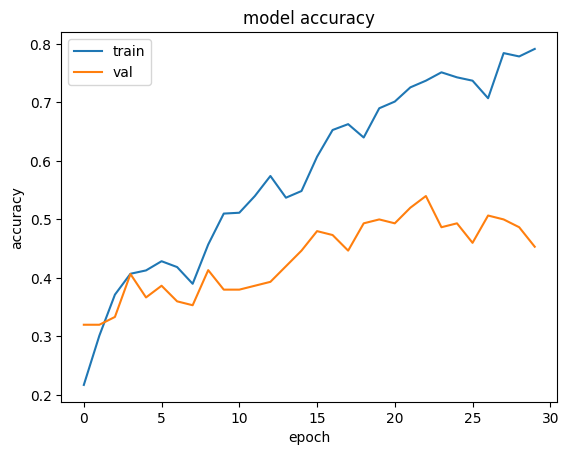

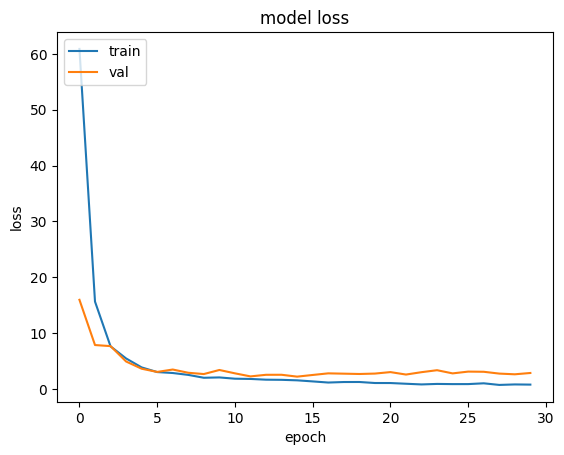

In [38]:
plot_categorical_accuracy(history)
plot_loss(history)
# plot_history(history)

## Save Model

In [40]:
model.save('../saved_models/mean_min_max_model_2')

2023-05-18 12:00:04.492711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-18 12:00:04.508719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-18 12:00:04.791130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-18 12:00

INFO:tensorflow:Assets written to: ../saved_models/mean_min_max_model_1/assets


2023-05-18 12:00:06.711031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-18 12:00:06.725238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-18 12:00:06.903542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-18 12:00

INFO:tensorflow:Assets written to: ../saved_models/mean_min_max_model_2/assets
